In [1]:
from os.path import join
from math import ceil

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## How to use this notebook

**Input**: Contig summary statistics table(s) `ctg_stats.csv` generated by the rule `concat_statistics` and contig length table(s) `ctg_lens.csv` generated by the rule `concat_lengths`. 

**Output**: 

1) Grouped bar graph(s) of the number of contigs, bases, and mean contig length made be each *de novo* assembler grouped by sample. 

2) Violin plots of all contigs lengths for each *de novo* assembler grouped by sample. 

### Steps

**Usage**: There is one cells that require user customization, described below. I designed this notebook specifically for the test dataset but tried to generalize as much as possible. The cell is indicated with the text `Customize here`. 

1) Add paths to the contig summary statistics tables you want to visualize to `stats_lst`.

- More summary tables can be added if you want to aggregate reports from several runs!

2) Customize how the samples are named and grouped using `samples_ordered` and `samples_labeled`. 

4) Customize the number of bar colours according to the number of steps used in the quality control process using `sample_colours`. 

## Load sample tables

### Contig summary statistics tables

In [2]:
# Set seaborn plotting aesthetics as default
sns.set()

In [31]:
# Customize here
# Add contig summary statistics tables for each sample set to a list
stats_lst = ['./test_out/hybrid_assembly/final_reports/ctg_stats.csv']
lens_lst = ['./test_out/hybrid_assembly/final_reports/ctg_lens.csv']
out_dir = './'

# If applicable, rename the samples in the table and/or set display names
samples_ordered = ['uhgg']
samples_labeled = ['UHGG'] # Optional- can also be merged_df['sample_name']

# If applicable (i.e.: used more than one assembler/assembly steps), set display names of the assemblers
# If not applicable (i.e.: only used one), leave the list empty
assemblers_ordered = ['0_hybridspades', '1_metaflye', '2_lr_polishing', '3_sr_polishing']
assemblers_labeled = ['HybridSPAdes', 'MetaFlye', 'Medaka', 'Polypolish'] # Optional- can also be merged_df['sample_name']

# The number of colours in each list is equal to the number of samples x assembly step combinations.
sample_asm_colours = ['#ffa600', '#ff6361', '#bc5090', '#003F5C']

In [32]:
# Merge the sample set dataframes and check their contents
df_lst = []
for df in stats_lst:
    df_lst.append(pd.read_csv(df, header = 0))
stats_df = pd.concat(df_lst)

stats_df

,sample_name,assembler,num_ctgs,total_size,mean_ctg_len
0,uhgg,0_hybridspades,3961,16400122,4140.40
1,uhgg,1_metaflye,106,3315846,31281.57
2,uhgg,2_lr_polishing,106,3305584,31184.75
3,uhgg,3_sr_polishing,106,3301136,31142.79


### Contig length tables

In [33]:
# Merge the sample set contig length dataframes and check their contents
df_lst = []
for df in lens_lst:
    df_lst.append(pd.read_csv(df, header = 0))
lengths_df = pd.concat(df_lst)

lengths_df.iloc[[1,500,1000],:] 

,sample_name,assembler,ctg_size
1,uhgg,0_hybridspades,48395
500,uhgg,0_hybridspades,8577
1000,uhgg,0_hybridspades,5349


### Count the number of contigs and bases kept with each minimum threshold

In [34]:
for i,s in enumerate(assemblers_ordered):
    tmp_df = lengths_df[lengths_df['assembler'] == s]
    num_ctgs = tmp_df.shape[0]
    asm_size = tmp_df['ctg_size'].sum()
    for n in [0, 1000, 2500, 10000, 20000, 50000, 100000, 500000]:
        larger_df = tmp_df[tmp_df['ctg_size'] >= n]
        num_larger = larger_df.shape[0]
        asm_larger = larger_df['ctg_size'].sum()
        print('{0} >{1} bp: {2} ({3:.3f}), {4} ({5:.3f})'.
              format(assemblers_labeled[i], n, num_larger, num_larger / num_ctgs, 
                     asm_larger, asm_larger / asm_size))

HybridSPAdes >0 bp: 3961 (1.000), 16400122 (1.000)
HybridSPAdes >1000 bp: 2956 (0.746), 15892925 (0.969)
HybridSPAdes >2500 bp: 1957 (0.494), 14227520 (0.868)
HybridSPAdes >10000 bp: 381 (0.096), 6133991 (0.374)
HybridSPAdes >20000 bp: 73 (0.018), 1943238 (0.118)
HybridSPAdes >50000 bp: 0 (0.000), 0 (0.000)
HybridSPAdes >100000 bp: 0 (0.000), 0 (0.000)
HybridSPAdes >500000 bp: 0 (0.000), 0 (0.000)
MetaFlye >0 bp: 106 (1.000), 3315846 (1.000)
MetaFlye >1000 bp: 105 (0.991), 3315846 (1.000)
MetaFlye >2500 bp: 105 (0.991), 3315846 (1.000)
MetaFlye >10000 bp: 95 (0.896), 3238205 (0.977)
MetaFlye >20000 bp: 73 (0.689), 2910581 (0.878)
MetaFlye >50000 bp: 19 (0.179), 1193245 (0.360)
MetaFlye >100000 bp: 1 (0.009), 133535 (0.040)
MetaFlye >500000 bp: 0 (0.000), 0 (0.000)
Medaka >0 bp: 106 (1.000), 3305584 (1.000)
Medaka >1000 bp: 105 (0.991), 3305584 (1.000)
Medaka >2500 bp: 105 (0.991), 3305584 (1.000)
Medaka >10000 bp: 94 (0.887), 3217929 (0.973)
Medaka >20000 bp: 73 (0.689), 2903541 (0.878

# Contig Summary Stats Dataviz

## Numbers of reads and bases for each sample's *de novo* assembly

In [35]:
def bar_plot(df, p, n, a):
    p = sns.barplot(data = df, x = 'assembler', y = p, \
                    order = assemblers_ordered, palette = sample_asm_colours, ax = a) 
    p.set_xticklabels(assemblers_labeled, size = 16)
    p.set_xlabel(None)
    p.set_ylabel(n, size = 20)
    return p

In [36]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    1  
# Columns: 3, one for each summary statistic.
col_labels = {'Num. Contigs'     : 'num_ctgs', 
              'Num. Bases'       : 'total_size', 
              'Mean Contig Size' : 'mean_ctg_len'}
fig, axs = plt.subplots(1, len(col_labels.keys()), figsize = (20,8)) # in.
fig.tight_layout(pad = 4)

In [37]:
for i, c in enumerate(col_labels):
    bar_plot(stats_df, col_labels[c], c, axs[i])

/tmp/ipykernel_1089598/3062982638.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(data = df, x = 'assembler', y = p, \
/tmp/ipykernel_1089598/3062982638.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(assemblers_labeled, size = 16)
/tmp/ipykernel_1089598/3062982638.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(data = df, x = 'assembler', y = p, \
/tmp/ipykernel_1089598/3062982638.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(assemblers_labeled, size = 16)
/tmp/i

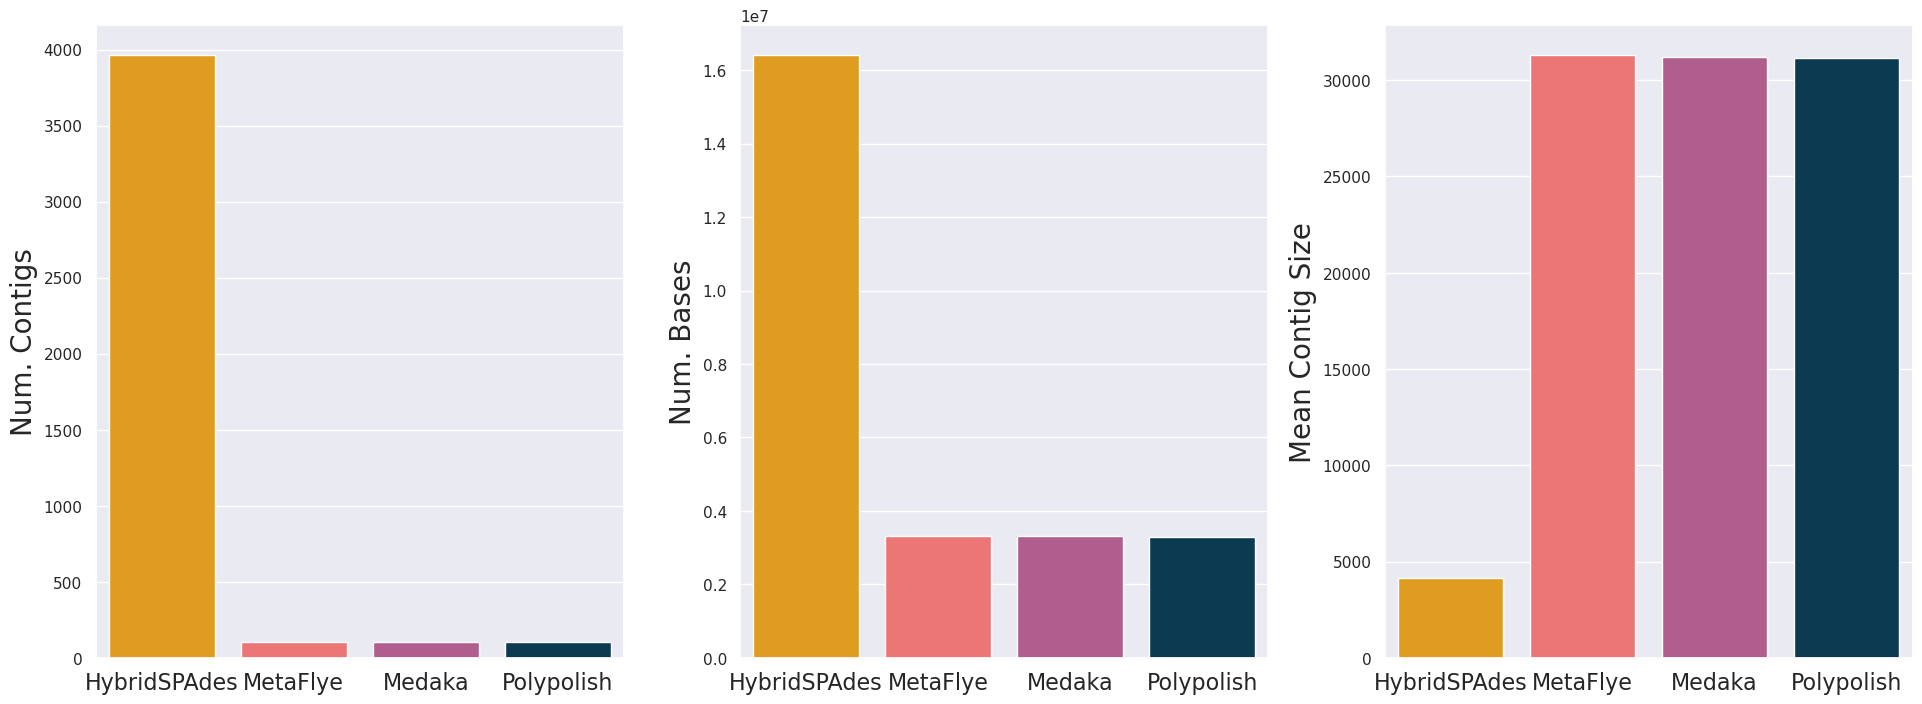

In [ ]:
fig

In [ ]:
# Save a large SVG without padding
fig.savefig('num_ctgs_bases_avgs.png', dpi = 1000, bbox_inches = 'tight')

## *De novo* assembled contig length distributions

In [39]:
# Set a maximum so that meaningful differences can be seen on one of the plots
min_len = 1000
max_len = 20000
max_lengths_df = lengths_df[lengths_df['ctg_size'] >= min_len]
range_lengths_df = max_lengths_df[max_lengths_df['ctg_size'] <= max_len]
print('Num. ctgs shorter than {} bp in length: {}'.format(min_len, lengths_df.shape[0] - max_lengths_df.shape[0]))
print('Num. ctgs. between {} and {} bp in length: {}'.format(min_len, max_len, range_lengths_df.shape[0]))
print('Num. ctgs. longer than {} bp in length: {}'.format(max_len, max_lengths_df.shape[0] - range_lengths_df.shape[0]))
max_lengths_df.iloc[[1,500,1000],:] 

Num. ctgs shorter than 1000 bp in length: 1008
Num. ctgs. between 1000 and 20000 bp in length: 2979
Num. ctgs. longer than 20000 bp in length: 292


,sample_name,assembler,ctg_size
2,uhgg,0_hybridspades,42037
501,uhgg,0_hybridspades,8564
1001,uhgg,0_hybridspades,5331


In [40]:
def violin_plot(df, a):
    p = sns.violinplot(data = df, x = 'assembler', y = 'ctg_size', \
                       order = assemblers_ordered, palette = sample_asm_colours, ax = a)
    p.set_xticklabels(assemblers_labeled, rotation = 45, ha = 'right') 
    p.set(xlabel = None) 
    p.set_ylabel('Contig Size (bp)', size = 16)
    return p

In [41]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    1
# Columns: 3 for all lengths, minimum-thresholded, and maximum-thresholded 
fig, axs = plt.subplots(1, 2, figsize = (12,6)) # in.
fig.tight_layout(pad = 4)

In [42]:
violin_plot(lengths_df, axs[0])
violin_plot(range_lengths_df, axs[1])

/tmp/ipykernel_1089598/3301768978.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.violinplot(data = df, x = 'assembler', y = 'ctg_size', \
/tmp/ipykernel_1089598/3301768978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(assemblers_labeled, rotation = 45, ha = 'right')
/tmp/ipykernel_1089598/3301768978.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.violinplot(data = df, x = 'assembler', y = 'ctg_size', \
/tmp/ipykernel_1089598/3301768978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xtickla

<Axes: ylabel='Contig Size (bp)'>

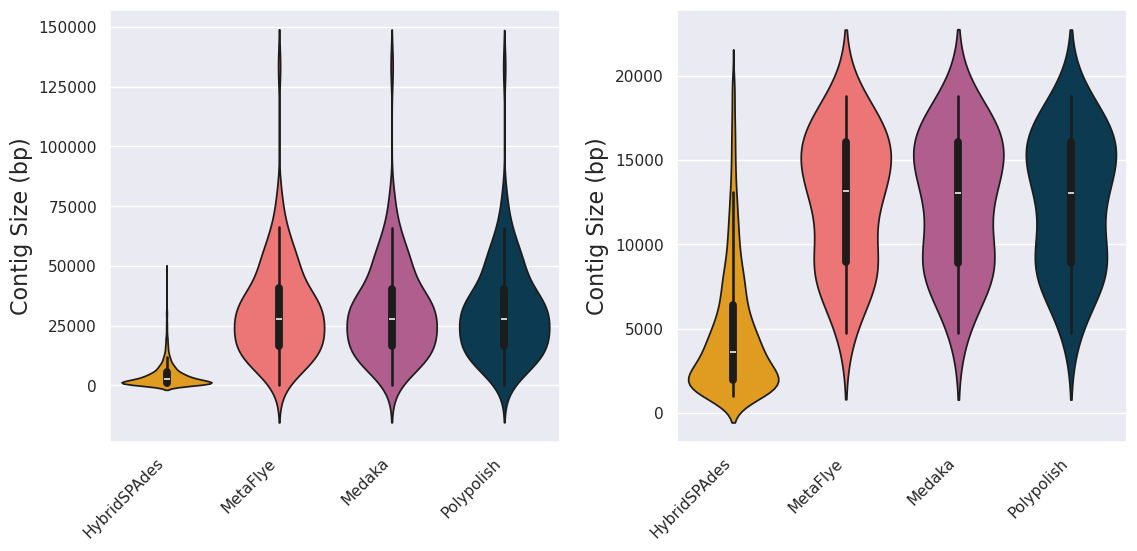

In [43]:
fig

In [ ]:
# Save a large SVG without padding
fig.savefig('hist_ctgs_samples.png', dpi = 1000, bbox_inches = 'tight')